In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [7]:
device = "mps"
block_size = 100
test_size = 1500
batch_size = 64

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [8]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=44, num_layers=5):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x + F.sigmoid(self.q(x)) * F.pad(x[:, :T-1, :], (0, 0, 1, 0))
        x = x + self.mlp(x)
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=30, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 95.9 K
-------------------------------
95.9 K    Trainable params
0         Non-trainable params
95.9 K    Total params
0.384     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 78.63it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


And nowP<<3B88Tvkiz4""
*Q<<gg3ss3<<333::ööJ0iD:]Oöy"9aR4""öRvqzWYYeeRc9
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 118/118 [00:02<00:00, 49.87it/s, loss=1.96, v_num=126]And nowl."

"Hay sand ther, wat by brow in ours. "So," we too, and hop,
Epoch 3: 100%|██████████| 118/118 [00:02<00:00, 48.13it/s, loss=1.6, v_num=126, test_loss=1.720] And now his to push, all.

Ohn is of he want down self he how the walk 
Epoch 5: 100%|██████████| 118/118 [00:02<00:00, 48.06it/s, loss=1.54, v_num=126, test_loss=1.560]And now.

"You cut inst are they are teach a book.

Tom they hale purse
Epoch 6: 100%|██████████| 118/118 [00:02<00:00, 48.54it/s, loss=1.51, v_num=126, test_loss=1.570]And now," warned.

"I sat. At to give to be the come to the found the b
Epoch 9: 100%|██████████| 118/118 [00:02<00:00, 47.95it/s, loss=1.47, v_num=126, test_loss=1.520]And now when threw a big.

It as they will bit want ough fort of.  He w
Epoch 10: 100%|██████████| 118/118 [00:02<00:00, 47.55it/s, loss=1.45, v_num=126, test_loss=1.470]And now," answered had paper the cons feet me."

"What before?" ask my 
Ep

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 118/118 [00:02<00:00, 43.91it/s, loss=1.35, v_num=126, test_loss=1.340]


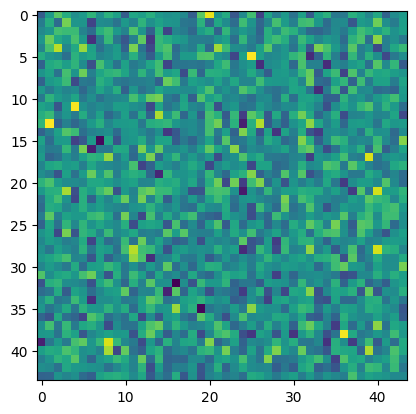

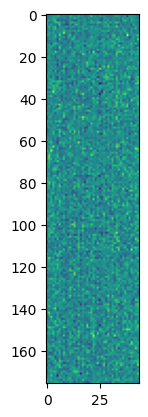

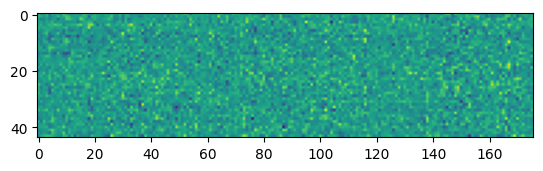

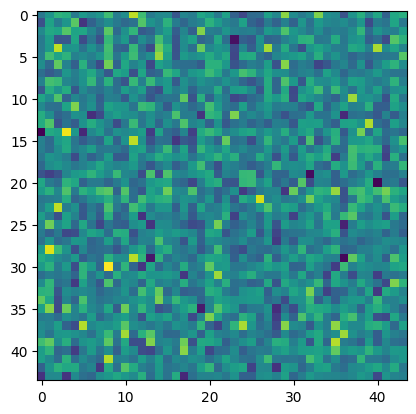

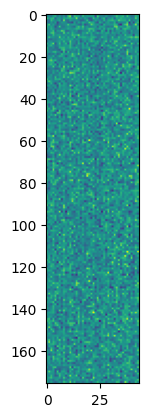

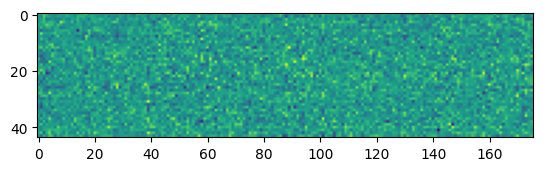

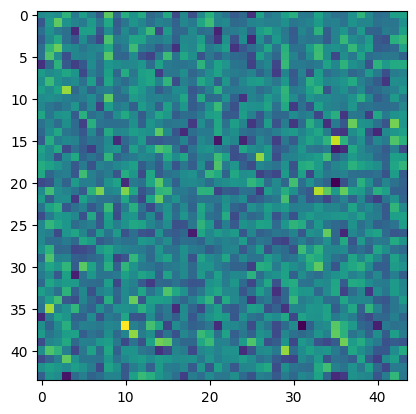

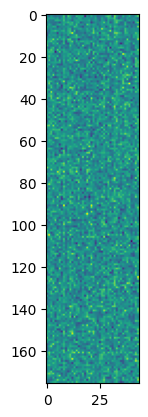

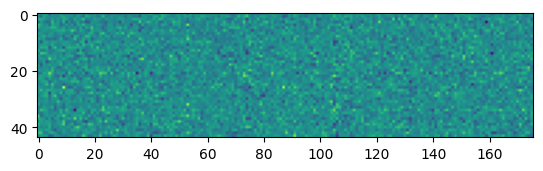

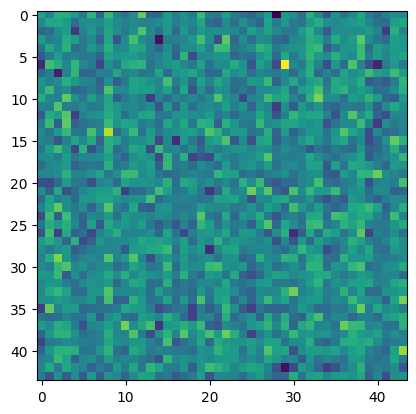

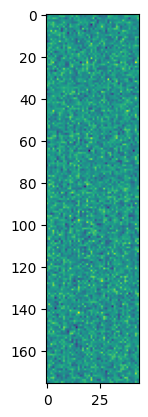

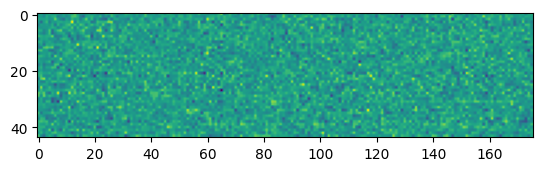

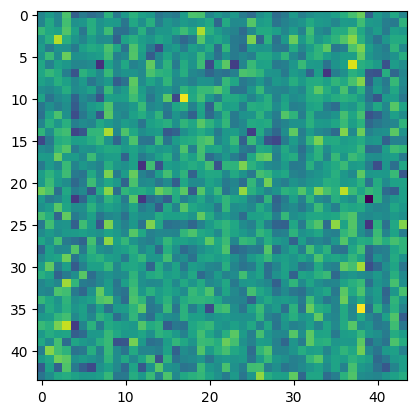

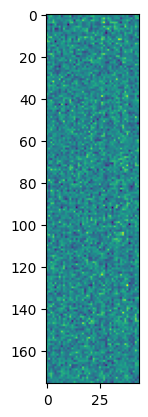

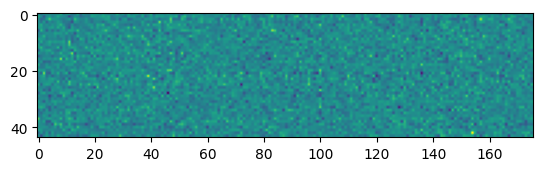

In [9]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.q.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [10]:
print(model.generate("O God, O God!", 650))

O God, O God!" sang out and going at the man in fighting to sell.

"But I went again at there were, he could be a boat, with the time.

"I'd remable calls of and she added them for she could go isn't making straight a shot with went to take the body home. And there we came the ponies where he turn is thicked to, still!" he say," was which I am nutip, about Mh, and there did," said Russ. Wil-od-ly dry, sorry heat, and he stood that will fire, if our men had a tree if throweven home she said.

Hello will give wratched to see is not school. "Who along, welconvest have anything to seen was a little fishes staylous little, and I have strang the trainly ate has
